# Import package 
(first you need install energyflow :pip install energyflow)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.axes as ax

# Define function

In [2]:
def Image_to_EFP_inputs(x, R = 1.2):
    bins = x.shape
    eta = np.zeros(bins)
    eta[:] = (np.arange(bins[0])-bins[0]/2+0.5)/bins[0]*R
    phi = np.zeros(bins)
    phi[:] = (np.arange(bins[0])-bins[0]/2+0.5)/bins[0]*R
    phi = np.transpose(phi, [1,0])
    basis = x!=0
    basis = basis.astype(np.int32)
    eta = basis*eta
    phi = basis*phi
    m = basis*0
    
    eta = eta.flatten()
    phi = phi.flatten()
    pt = x.flatten()
    m = m.flatten()
    
    eta = np.expand_dims(eta, axis = -1)
    pt = np.expand_dims(pt, axis = -1)
    phi = np.expand_dims(phi, axis = -1)
    m = np.expand_dims(m, axis = -1)
    basis = basis.flatten()
    
    rs = np.concatenate([pt, eta, phi, m], axis=-1)
    rs = rs[basis!=0]
    return rs

def image_to_EFP(x, dmax = 5, beta = 0.5):
    x = Image_to_EFP_inputs(x)
    efp = energyflow.EFPSet(('d<=', dmax), measure='hadr', beta=beta,coords='ptyphim').compute(event = x, zs=None, thetas=None, nhats=None,  batch_call= None)
    return efp

# Load data

In [3]:
outfile = "/home/ja2006203966/script/Network/data/H5/CNN/Train.h5"
hf = h5py.File(outfile, 'r')
print(hf.keys())
# lb = ['mask', 'points', 'features']
X_train = hf["X_train"][()]
X_val = hf["X_val"][()]
X_test = hf["X_test"][()]


y_train = hf["y_train"][()]
y_val = hf["y_val"][()]
y_test = hf["y_test"][()]

hf.close()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


# Calculate EFP

## With N cores

In [30]:
EFPinputs = []
for i in tqdm(X_train):
    EFPinputs.append(Image_to_EFP_inputs(i))
EFPinputs = np.array(EFPinputs)
    
    

100%|██████████| 238800/238800 [00:47<00:00, 5051.72it/s]


In [31]:
N=100
delta = int(len(EFPinputs)/N)
EFP = []
dmax = 5
beta = 0.5
for i in tqdm(range(N)):
    
    x = EFPinputs[i*delta:(i+1)*delta]
    efp = energyflow.EFPSet(('d<=', dmax), measure='hadr', beta= beta,coords='ptyphim').batch_compute(x, n_jobs=40)
    if i==0:
        EFP = efp
    else :
        EFP = np.append(EFP, efp, axis=0 )
    
# efp = energyflow.EFPSet(('d<=', 5), measure='hadr', beta= 0.5,coords='ptyphim').batch_compute(EFPinputs, n_jobs=20)

100%|██████████| 100/100 [10:43<00:00,  6.43s/it]


In [32]:
SVJ_EFP = []
QCDJ_EFP = []

for i in tqdm(range(len(EFPinputs))):
    if y_train[i] == 1:
        SVJ_EFP.append(EFP[i])
    if y_train[i] == 0:
        QCDJ_EFP.append(EFP[i])
    

100%|██████████| 238800/238800 [00:00<00:00, 358407.99it/s]


In [11]:
EFP.shape

(238800, 102)

## With single core

In [4]:
## I think this part need to speed up
SVJ_EFP = []
QCDJ_EFP = []

for i in tqdm(range(2000)):
    if y_train[i] == 1:
        SVJ_EFP.append(image_to_EFP(X_train[i]))
    if y_train[i] == 0:
        QCDJ_EFP.append(image_to_EFP(X_train[i]))



100%|██████████| 2000/2000 [04:17<00:00,  7.77it/s]


# Show EFP plot and save as PNG

100%|██████████| 102/102 [00:19<00:00,  5.33it/s]


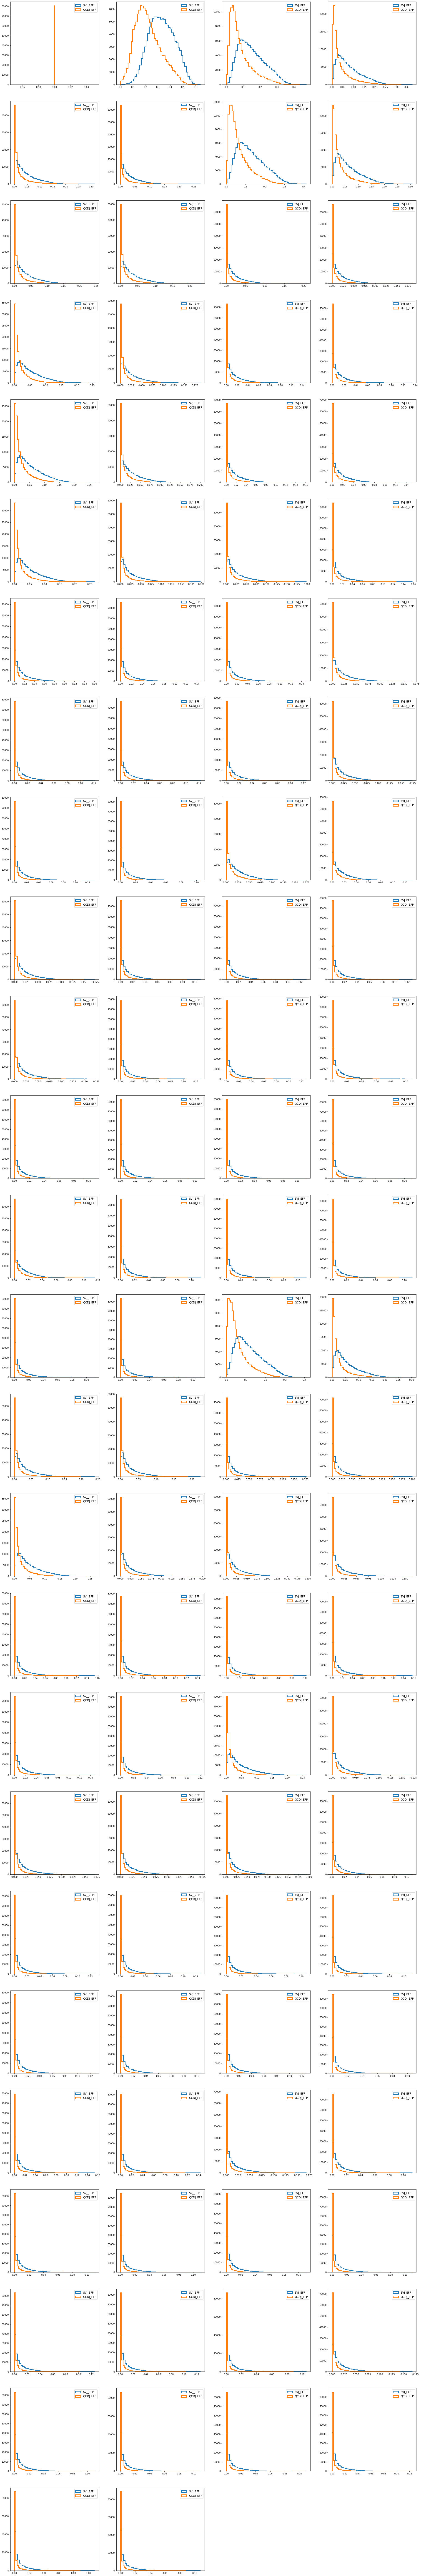

In [20]:
tagsize = 12
bins = 50

NEFP = SVJ_EFP[0].shape[0]
plt.figure(figsize=(4*8, 8*(int(NEFP/4)+1)))
for N in tqdm(range(NEFP)):
    sig = [i[N] for i in SVJ_EFP]
    bkg = [i[N] for i in QCDJ_EFP]
    plt.subplot(int(NEFP/4)+1 ,4, N+1)
    plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
    plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
    plt.legend(prop={'size': tagsize}) # plot label tag
plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP"+str(NEFP)+".png")
plt.show()

# Calculate EFP with filter

In [21]:
filters = np.load('/home/ja2006203966/script/Network/data/H5/Transformer/Filter.npy')
filters

array([[0.30597633, 0.252315  , 0.46830478, ..., 0.3419009 , 0.3143918 ,
        0.0432907 ],
       [0.29771987, 0.00693411, 0.36878404, ..., 0.49984786, 0.44163486,
        0.02703709],
       [0.39082456, 0.3855754 , 0.13063623, ..., 0.6041548 , 0.14960472,
        0.05453513],
       ...,
       [0.01317989, 0.00214359, 0.03096059, ..., 0.0452201 , 0.05039362,
        0.05306132],
       [0.00738754, 0.0174447 , 0.02249143, ..., 0.07714292, 0.00645948,
        0.0008411 ],
       [0.00961999, 0.01491667, 0.00886723, ..., 0.00147965, 0.09275828,
        0.01146053]], dtype=float32)

## N cores

In [22]:
EFPinputsf = []
for i in tqdm(X_train):
    EFPinputsf.append(Image_to_EFP_inputs(i*filters))
EFPinputsf = np.array(EFPinputsf)
    
    

100%|██████████| 238800/238800 [00:49<00:00, 4836.45it/s]


In [23]:
N=100
delta = int(len(EFPinputsf)/N)
EFPf = []
dmax = 5
beta = 0.5
for i in tqdm(range(N)):
    
    x = EFPinputsf[i*delta:(i+1)*delta]
    efp = energyflow.EFPSet(('d<=', dmax), measure='hadr', beta= beta,coords='ptyphim').batch_compute(x, n_jobs=40)
    if i==0:
        EFPf = efp
    else :
        EFPf = np.append(EFPf, efp, axis=0 )
    
# efp = energyflow.EFPSet(('d<=', 5), measure='hadr', beta= 0.5,coords='ptyphim').batch_compute(EFPinputs, n_jobs=20)

100%|██████████| 100/100 [09:07<00:00,  5.47s/it]


In [25]:
SVJf_EFP = []
QCDJf_EFP = []

for i in tqdm(range(len(EFPf))):
    if y_train[i] == 1:
        SVJf_EFP.append(EFPf[i])
    if y_train[i] == 0:
        QCDJf_EFP.append(EFPf[i])
    

100%|██████████| 238800/238800 [00:00<00:00, 356482.82it/s]


## Single core

In [7]:
## I think this part need to speed up
SVJf_EFPf = []
QCDJf_EFPf = []
filters = np.load('/home/ja2006203966/script/Network/data/H5/Transformer/Filter.npy')
filters2 = np.load('/home/ja2006203966/script/Network/data/H5/Transformer/Filters_1.npy')
filters3 = np.load('/home/ja2006203966/script/Network/data/H5/Transformer/Filters_4.npy')

for i in tqdm(range(2000)):
    if y_train[i] == 1:
        SVJf_EFPf.append(image_to_EFP(X_train[i]*filters))
    if y_train[i] == 0:
        QCDJf_EFPf.append(image_to_EFP(X_train[i]*filters))



100%|██████████| 2000/2000 [04:18<00:00,  7.75it/s]


100%|██████████| 102/102 [00:19<00:00,  5.22it/s]


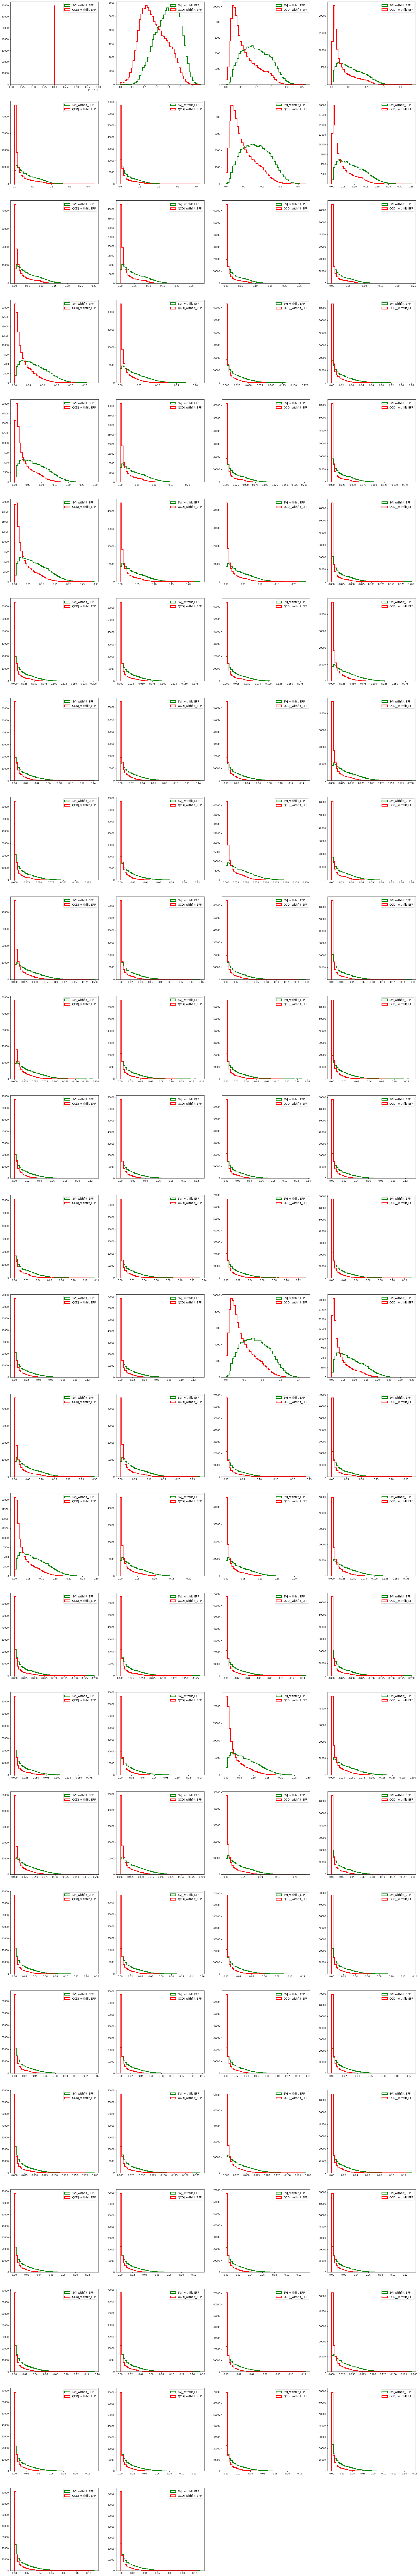

In [27]:
tagsize = 12
bins = 50

NEFP = SVJf_EFP[0].shape[0]
plt.figure(figsize=(4*8, 8*(int(NEFP/4)+1)))
for N in tqdm(range(NEFP)):
    sigf = [i[N] for i in SVJf_EFP]
    bkgf = [i[N] for i in QCDJf_EFP]
#     sig = [i[N] for i in SVJ_EFP]
#     bkg = [i[N] for i in QCDJ_EFP]
    
    plt.subplot(int(NEFP/4)+1 ,4, N+1)
#     plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
#     plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
    plt.hist(sigf, bins=bins, histtype='step', color='g', linewidth=3, label = 'SVJ_withfilt_EFP' )
    plt.hist(bkgf, bins=bins, histtype='step', color='r', linewidth=3,label = 'QCDJ_withfilt_EFP' )
    
    plt.legend(prop={'size': tagsize}) # plot label tag
# plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_withfilter_"+str(NEFP)+".png")
plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_filter_"+str(NEFP)+".png")

plt.show()

# Comparison

100%|██████████| 102/102 [00:37<00:00,  2.70it/s]


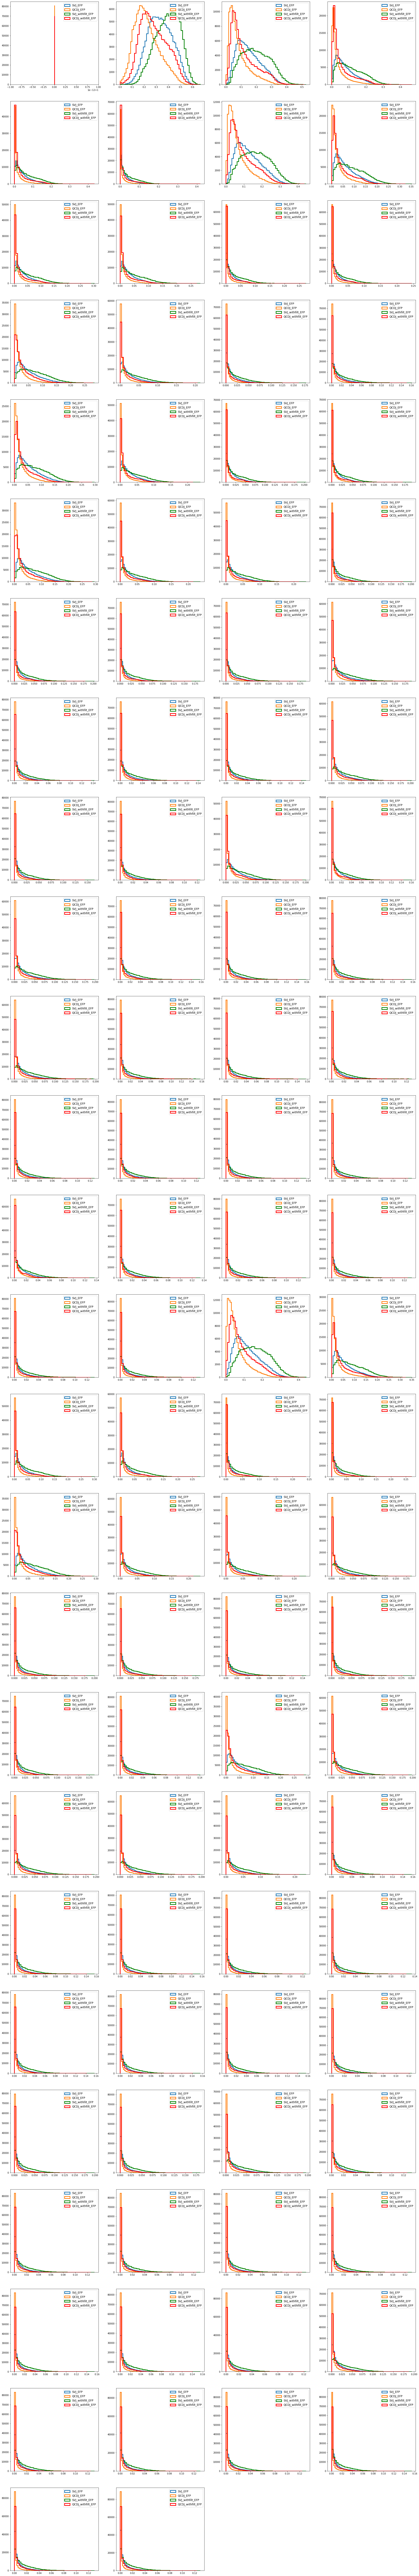

In [33]:
tagsize = 12
bins = 50

NEFP = SVJf_EFP[0].shape[0]
plt.figure(figsize=(4*8, 8*(int(NEFP/4)+1)))
for N in tqdm(range(NEFP)):
    sigf = [i[N] for i in SVJf_EFP]
    bkgf = [i[N] for i in QCDJf_EFP]
    sig = [i[N] for i in SVJ_EFP]
    bkg = [i[N] for i in QCDJ_EFP]
    
    plt.subplot(int(NEFP/4)+1 ,4, N+1)
    plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
    plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
    plt.hist(sigf, bins=bins, histtype='step', color='g', linewidth=3, label = 'SVJ_withfilt_EFP' )
    plt.hist(bkgf, bins=bins, histtype='step', color='r', linewidth=3,label = 'QCDJ_withfilt_EFP' )
    
    plt.legend(prop={'size': tagsize}) # plot label tag
plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_withfilter_"+str(NEFP)+".png")
# plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_filter_"+str(NEFP)+".png")

plt.show()

# O(1000)

# Calculate EFP

## With N cores

In [4]:
EFPinputs = []
for i in tqdm(X_train):
    EFPinputs.append(Image_to_EFP_inputs(i))
EFPinputs = np.array(EFPinputs)
    
    

100%|██████████| 238800/238800 [00:47<00:00, 5060.71it/s]


In [5]:
N=100
delta = int(len(EFPinputs)/N)
EFP_1000 = []
dmax = 7
beta = 0.5
for i in tqdm(range(N)):
    
    x = EFPinputs[i*delta:(i+1)*delta]
    efp = energyflow.EFPSet(('d<=', dmax), measure='hadr', beta= beta,coords='ptyphim').batch_compute(x, n_jobs=40)
    if i==0:
        EFP_1000 = efp
    else :
        EFP_1000 = np.append(EFP_1000, efp, axis=0 )
    
# efp = energyflow.EFPSet(('d<=', 5), measure='hadr', beta= 0.5,coords='ptyphim').batch_compute(EFPinputs, n_jobs=20)

100%|██████████| 100/100 [39:53<00:00, 23.93s/it]


In [7]:
SVJ_EFP_1000 = []
QCDJ_EFP_1000 = []

for i in tqdm(range(len(EFPinputs))):
    if y_train[i] == 1:
        SVJ_EFP_1000.append(EFP_1000[i])
    if y_train[i] == 0:
        QCDJ_EFP_1000.append(EFP_1000[i])
    

100%|██████████| 238800/238800 [00:00<00:00, 349518.38it/s]


In [12]:
np.save("/home/ja2006203966/script/Network/data/H5/EFP/EFP_1000.npy",EFP_1000)

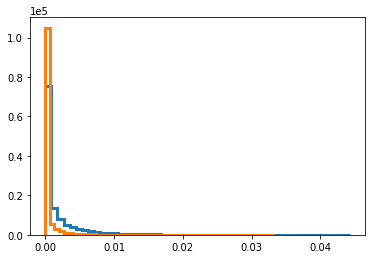

In [35]:
# plt.ticklabel_format()  
# matplotlib.axes
a = plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
b = plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
# ax.Axes.ticklabel_format( axis='y', style='sci')
plt.ticklabel_format( axis='y', style='sci', scilimits=(0,0))
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]


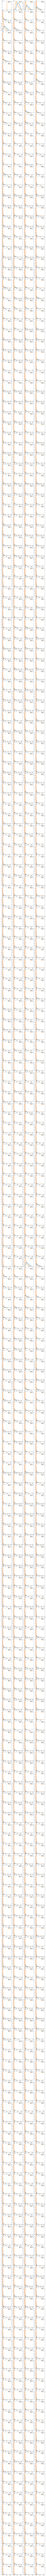

In [36]:
tagsize = 6
bins = 50
sigle_size = 3
NEFP = SVJ_EFP_1000[0].shape[0]
plt.figure(figsize=(4*sigle_size, sigle_size*(int(NEFP/4)+1))) #siggle_size*(int(NEFP/4)+1)*72  <= 2**16
for N in tqdm(range(NEFP)):
    sig = [i[N] for i in SVJ_EFP_1000]
    bkg = [i[N] for i in QCDJ_EFP_1000]
    plt.subplot(int(NEFP/4)+1 ,4, N+1)
    plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
    plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
    plt.ticklabel_format( axis='y', style='sci', scilimits=(0,0))
    
    plt.legend(prop={'size': tagsize}) # plot label tag
plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP"+str(NEFP)+".png")
plt.show()

In [11]:
2**16

65536

In [17]:
(4*3*72, 3*(int(NEFP/4)+1)*72)

(864, 54216)

In [14]:
1152/16

72.0

# Back up

In [23]:
image_to_EFP(X_train[0]).shape

(13,)

In [22]:
def image_to_EFP(x, dmax = 3, beta = 0.5):
    x = Image_to_EFP_inputs(x)
    efp = energyflow.EFPSet(('d<=', dmax), measure='hadr', beta=beta,coords='ptyphim').compute(event = x, zs=None, thetas=None, nhats=None,  batch_call= None)
    return efp

In [25]:
## I think this part need to speed up
SVJ_EFP = []
QCDJ_EFP = []
SVJf_EFP = []
QCDJf_EFP = []
filters = np.load('/home/ja2006203966/script/Network/data/H5/Transformer/Filter.npy')

for i in tqdm(range(2000)):
    if y_train[i] == 1:
        SVJ_EFP.append(image_to_EFP(X_train[i]))
        SVJf_EFP.append(image_to_EFP(X_train[i]*filters))
    if y_train[i] == 0:
        QCDJ_EFP.append(image_to_EFP(X_train[i]))
        QCDJf_EFP.append(image_to_EFP(X_train[i]*filters))
        




100%|██████████| 2000/2000 [07:43<00:00,  4.32it/s]


100%|██████████| 13/13 [00:00<00:00, 39.75it/s]


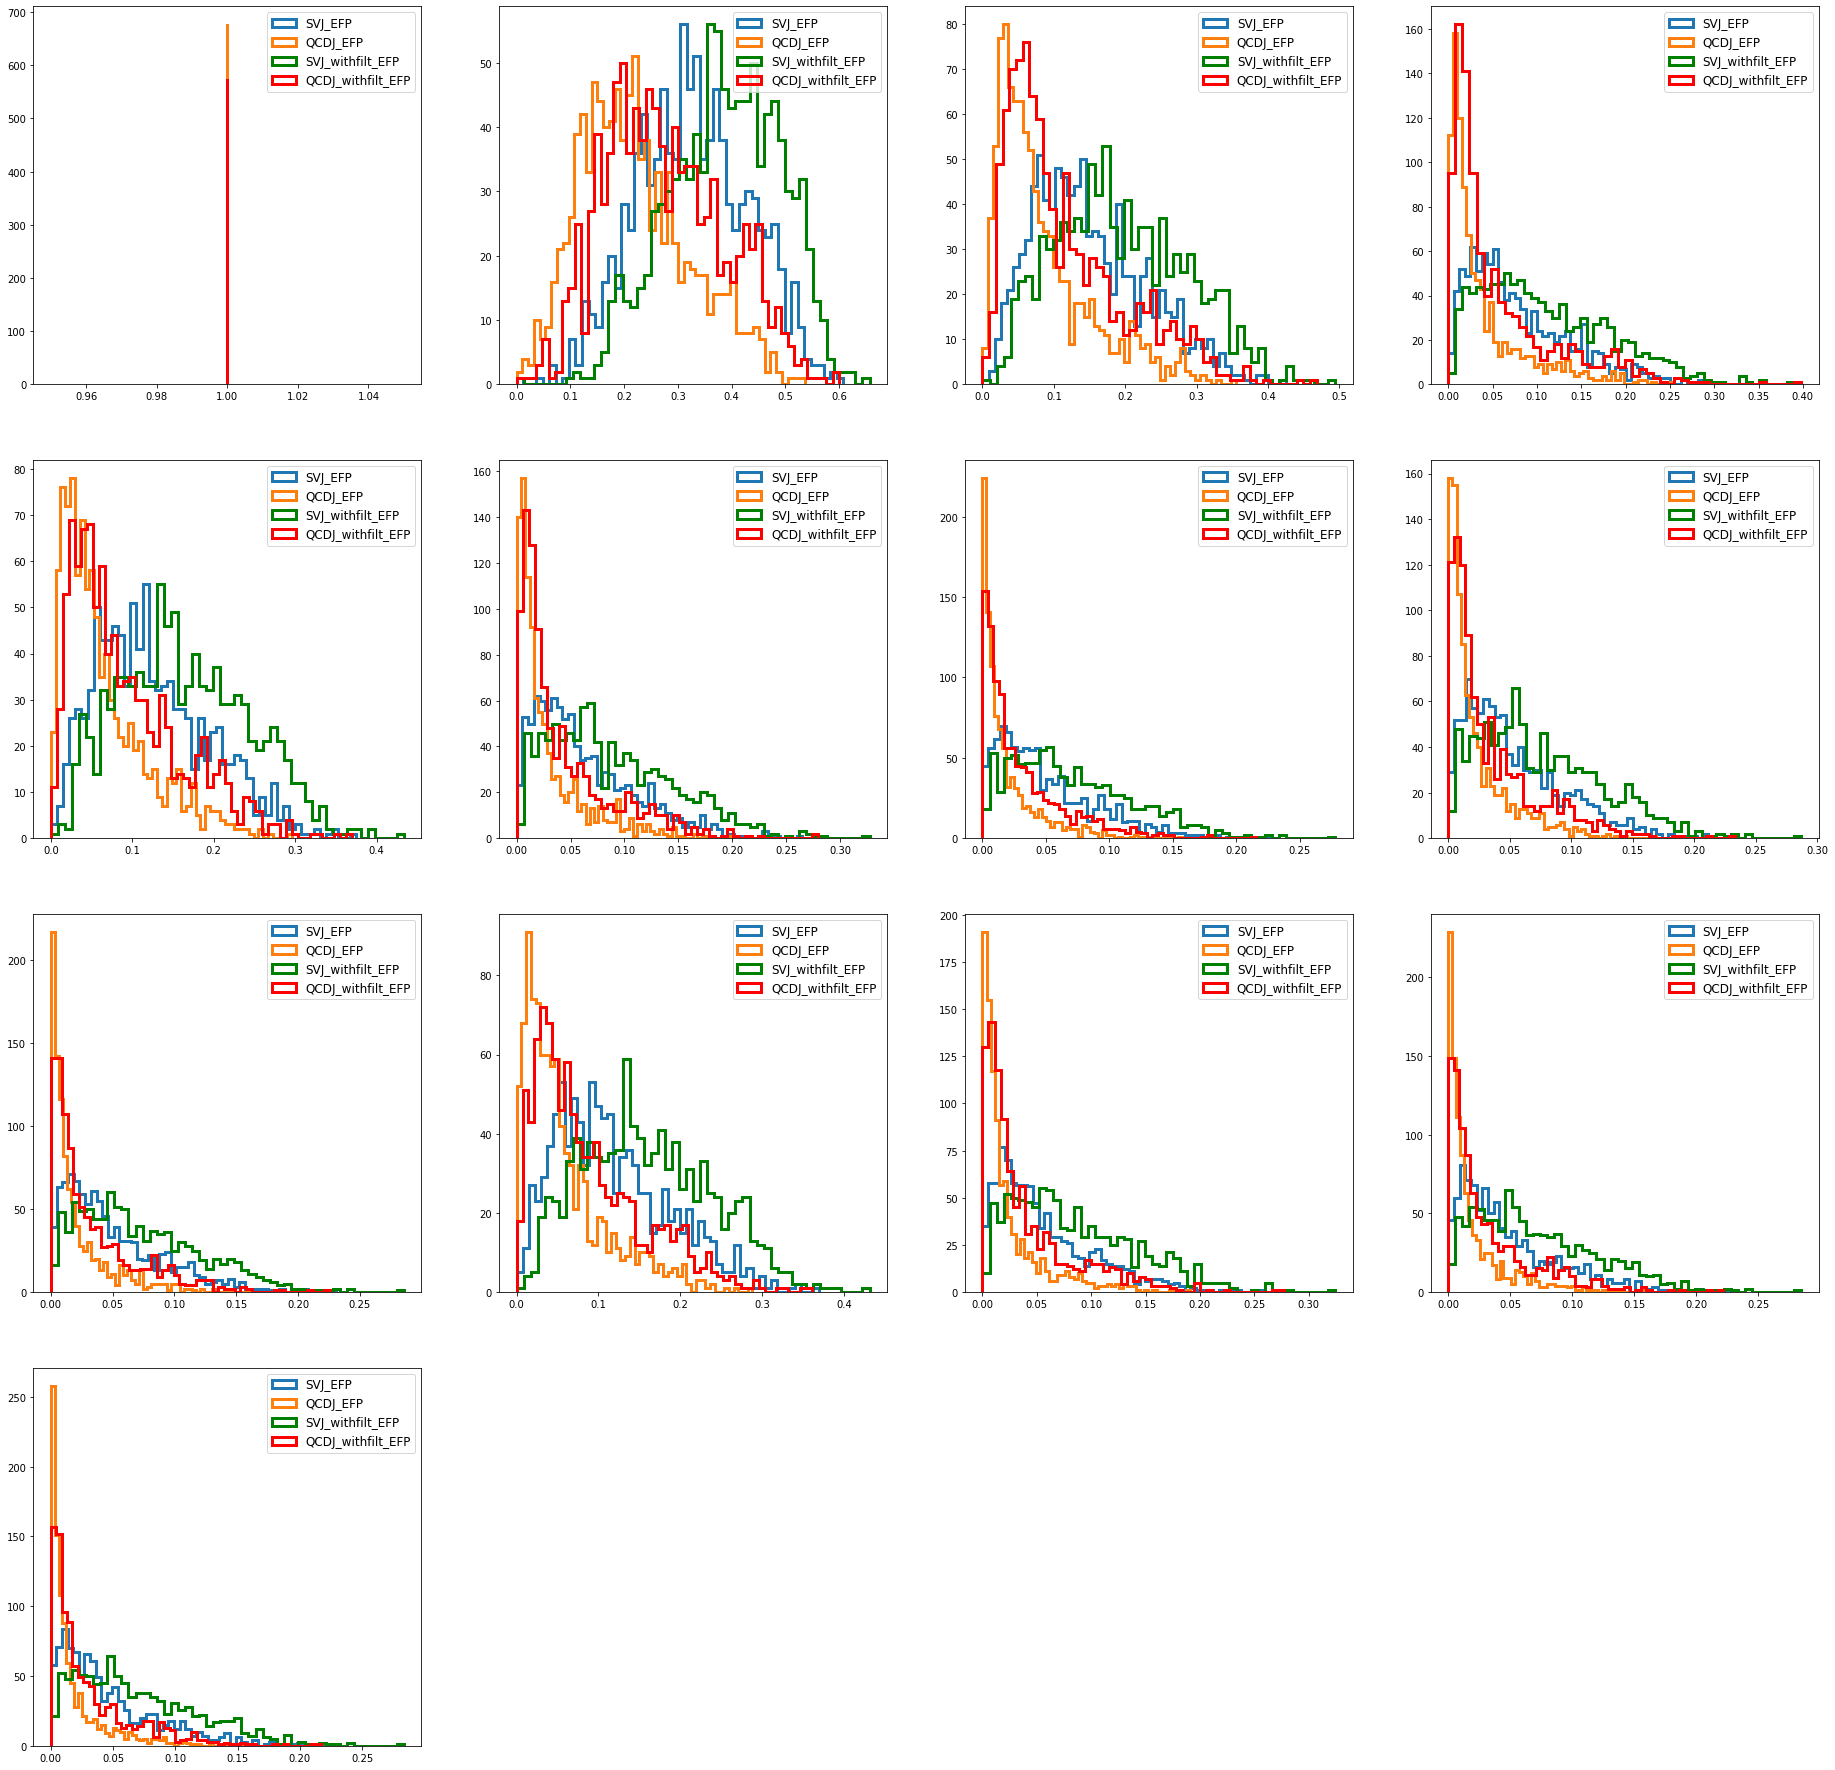

In [26]:
tagsize = 12
bins = 50

NEFP = SVJf_EFP[0].shape[0]
plt.figure(figsize=(4*8, 8*(int(NEFP/4)+1)))
for N in tqdm(range(NEFP)):
    sigf = [i[N] for i in SVJf_EFP]
    bkgf = [i[N] for i in QCDJf_EFP]
    sig = [i[N] for i in SVJ_EFP]
    bkg = [i[N] for i in QCDJ_EFP]
    
    plt.subplot(int(NEFP/4)+1 ,4, N+1)
    plt.hist(sig, bins=bins, histtype='step', linewidth=3, label = 'SVJ_EFP' )
    plt.hist(bkg, bins=bins, histtype='step', linewidth=3,label = 'QCDJ_EFP' )
    plt.hist(sigf, bins=bins, histtype='step', color='g', linewidth=3, label = 'SVJ_withfilt_EFP' )
    plt.hist(bkgf, bins=bins, histtype='step', color='r', linewidth=3,label = 'QCDJ_withfilt_EFP' )
    
    plt.legend(prop={'size': tagsize}) # plot label tag
# plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_withfilter_"+str(NEFP)+".png")
# plt.savefig("/home/ja2006203966/script/Network/data/H5/EFP/EFP_filter_"+str(NEFP)+".png")

plt.show()